# Improving Olist's Estimated Delivery Time (ETA)

👉 `Estimated Time of Arrival (ETA)` is a key component of modern e-commerce services. It allows companies to manage customer expectations by showing a predicted date for customer delivery.

🎯 In this challenge, we will build a predictive model that `estimates the wait time` of an order.

☑️ Olist already has its own predictions under the variable `expected_wait_time`

🚀 Let's challenge ourselves to do better predictions and at the end of this recap, 
we will compare:
* our `estimated_wait_time`
* Olist's `expected_wait_time`
* the real `wait_time` for each order delivered

## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
root_path = os.path.join(os.getcwd(),'..')
if root_path not in sys.path:
    sys.path.append(root_path)

from utils.order import Order

order_instance = Order()
orders = order_instance.get_training_data(with_distance_seller_customer=True)

## 1. Baseline Model - Olist’s current ETA model

❓ **What's the baseline I want to optimize?**

👆 The delta between Olist' `expected_wait_time` and the real `wait_time`

In [3]:
orders.head(3)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95872 entries, 0 to 95879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95872 non-null  object 
 1   wait_time                 95872 non-null  float64
 2   expected_wait_time        95872 non-null  float64
 3   delay_vs_expected         95872 non-null  float64
 4   order_status              95872 non-null  object 
 5   dim_is_five_star          95872 non-null  int64  
 6   dim_is_one_star           95872 non-null  int64  
 7   review_score              95872 non-null  int64  
 8   number_of_products        95872 non-null  int64  
 9   number_of_sellers         95872 non-null  int64  
 10  price                     95872 non-null  float64
 11  freight_value             95872 non-null  float64
 12  distance_seller_customer  95872 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


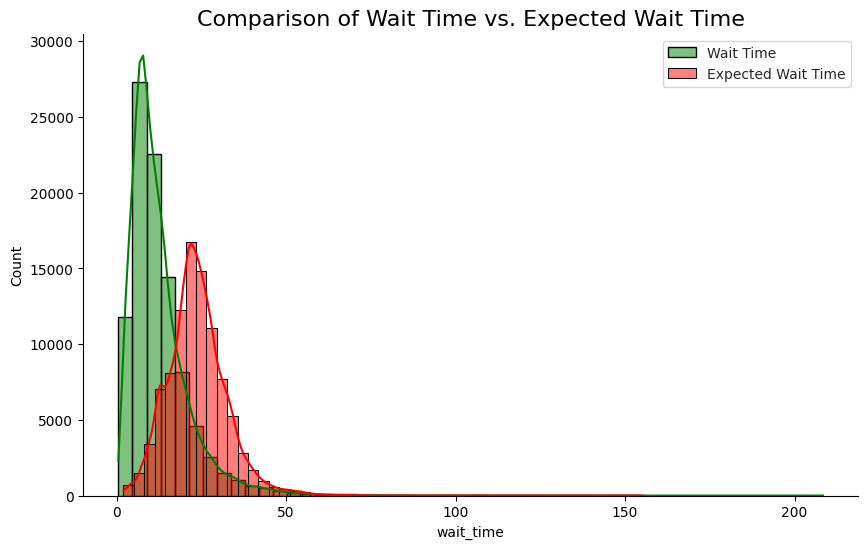

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(orders['wait_time'], bins=50, color='green', kde=True, label='Wait Time')
sns.histplot(orders['expected_wait_time'], bins=50, color='red', kde=True, label='Expected Wait Time')
plt.title('Comparison of Wait Time vs. Expected Wait Time', fontsize=16)

sns.set_style("whitegrid")
sns.despine()
plt.legend()

❓ **What is the median wait time and the median expected wait time?** 

In [6]:
wait_time_median = orders['wait_time'].median()
expected_wait_time_median = orders['expected_wait_time'].median()

print(f'Wait Time Median:', wait_time_median)
print(f'Expected Wait Time Median:', expected_wait_time_median)

Wait Time Median: 10.203726851851851
Expected Wait Time Median: 23.230555555555554


❓ **Whats the baseline RMSE?** 

**Note:**  
The errors considered here are the misapproximations from Olist in terms of waiting time.

RMSE = √(Σ(actual - predicted)² / n)

In [21]:
baseline_RMSE = np.sqrt((((orders['wait_time'] - orders['expected_wait_time'])**2)).mean())
print(f'Baseline RMSE:', baseline_RMSE)

Baseline RMSE: 15.110701386210625


## 2. OLS Multivariate Model

I will create an OLS model using the `statsmodel.api.OLS` method this time.

### 2.1 Prepare the dataset with the features X and the target Y

In [8]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [9]:
X = orders[[
    'number_of_products',
    'number_of_sellers',
    'price',
    'freight_value',
    'distance_seller_customer'
    ]]

y = orders['wait_time'].copy()

⚖️ Standardizing (`z-score`) each feature of X to compare regression coefficients that will result from the OLS:

In [10]:
X_std = X.copy()

for f in X.columns:
    mu = X[f].mean()
    sigma = X[f].std()
    X_std[f] = X[f].map(lambda x: (x - mu) / sigma)

X_std

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...
95875,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
95876,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
95877,-0.264595,-0.112544,0.333684,1.964490,0.617630
95878,1.601605,-0.112544,1.075186,2.715522,-0.387558


⚠️ With this `statsmodel.api.OLS`, it's always needed to add a constant "intercept" to the features dataset:

In [11]:
X_std['constant'] = 1
X_std

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,constant
0,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475,1
1,-0.264595,-0.112544,-0.086640,0.000467,0.429743,1
2,-0.264595,-0.112544,0.111748,-0.164053,-0.145495,1
3,-0.264595,-0.112544,-0.441525,0.206815,2.054621,1
4,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115,1
...,...,...,...,...,...,...
95875,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033,1
95876,-0.264595,-0.112544,0.183977,-0.123156,-0.212797,1
95877,-0.264595,-0.112544,0.333684,1.964490,0.617630,1
95878,1.601605,-0.112544,1.075186,2.715522,-0.387558,1


### 2.2 Running OLS with `statsmodels` and printing `summary`

In [12]:
model = sm.OLS(y, X_std).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3676.
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:12:56   Log-Likelihood:            -3.4301e+05
No. Observations:               95872   AIC:                         6.860e+05
Df Residuals:                   95866   BIC:                         6.861e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.3104      0.033     -9.481      0.000      -0.375      -0.246
number_of_sellers           -0.3557      0.029    -12.174      0.000      -0.413      -0.298
price                        0.0474      0.031      1.542      0.123      -0.013       0.108
freight_value                0.6392      0.036     17.717      0.000       0.568       0.710
distance_seller_customer     3.5219      0.030    117.298      0.000       3.463       3.581
constant                    12.5134      0.028    447.350      0.000      12.459      12.568
==============================================================================
Omnibus:                    91515.661   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10123039.937
Skew:                           4.333   Prob(JB):                         0.00
Kurtosis:                      52.589   Cond. No.                         2.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Checking the performance of my OLS model

### Goodness of fit

❓ **Who has the best predictions, me or Olist?** 

- Computing my predictions and storing them in `y_pred`

In [14]:
# Olist predictions
y_expected_olist = orders['expected_wait_time']

# Your predictions
y_pred = model.predict(X_std)

# The real waiting times
y_true = orders['wait_time']

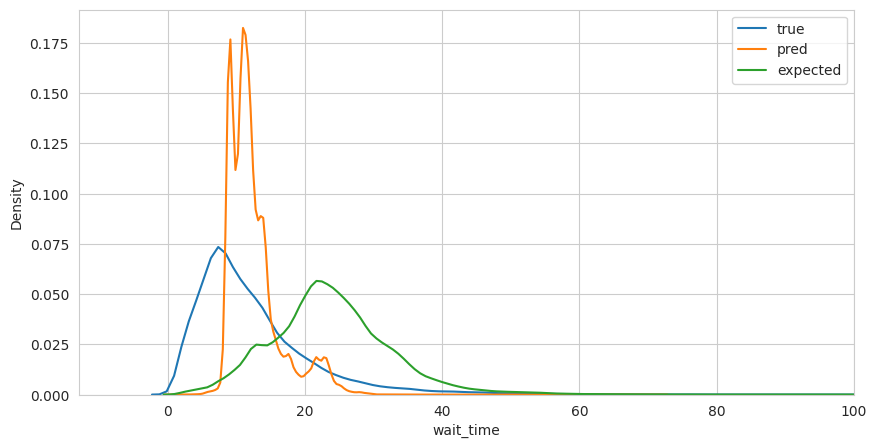

In [15]:
plt.figure(figsize = (10,5))
sns.kdeplot(y_true, label = 'true')
sns.kdeplot(y_pred, label = 'pred')
sns.kdeplot(y_expected_olist, label = 'expected')
plt.xlim(xmax=100)
plt.legend()

In [20]:
residuals = y_pred - y_true
RMSE_pred = np.sqrt((residuals**2).mean())
print(f'My RMSE:', RMSE_pred)

My RMSE: 8.660865913751271


Just as a reminder, Olist's RMSE was equal to : 👇

In [22]:
print(f'Baseline RMSE:', baseline_RMSE)

Baseline RMSE: 15.110701386210625


❓ **Did I really beat Olist's Data Scientists? I cannot really say that...**

- In many e-commerce and delivery services, the ETA is often overestimated...
- When customers receive their orders earlier than expected, they are more likely to be satisfied.

### Partial correlations

👉 Visualizing partial correlations with `sm.graphics.plot_partregress_grid`

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


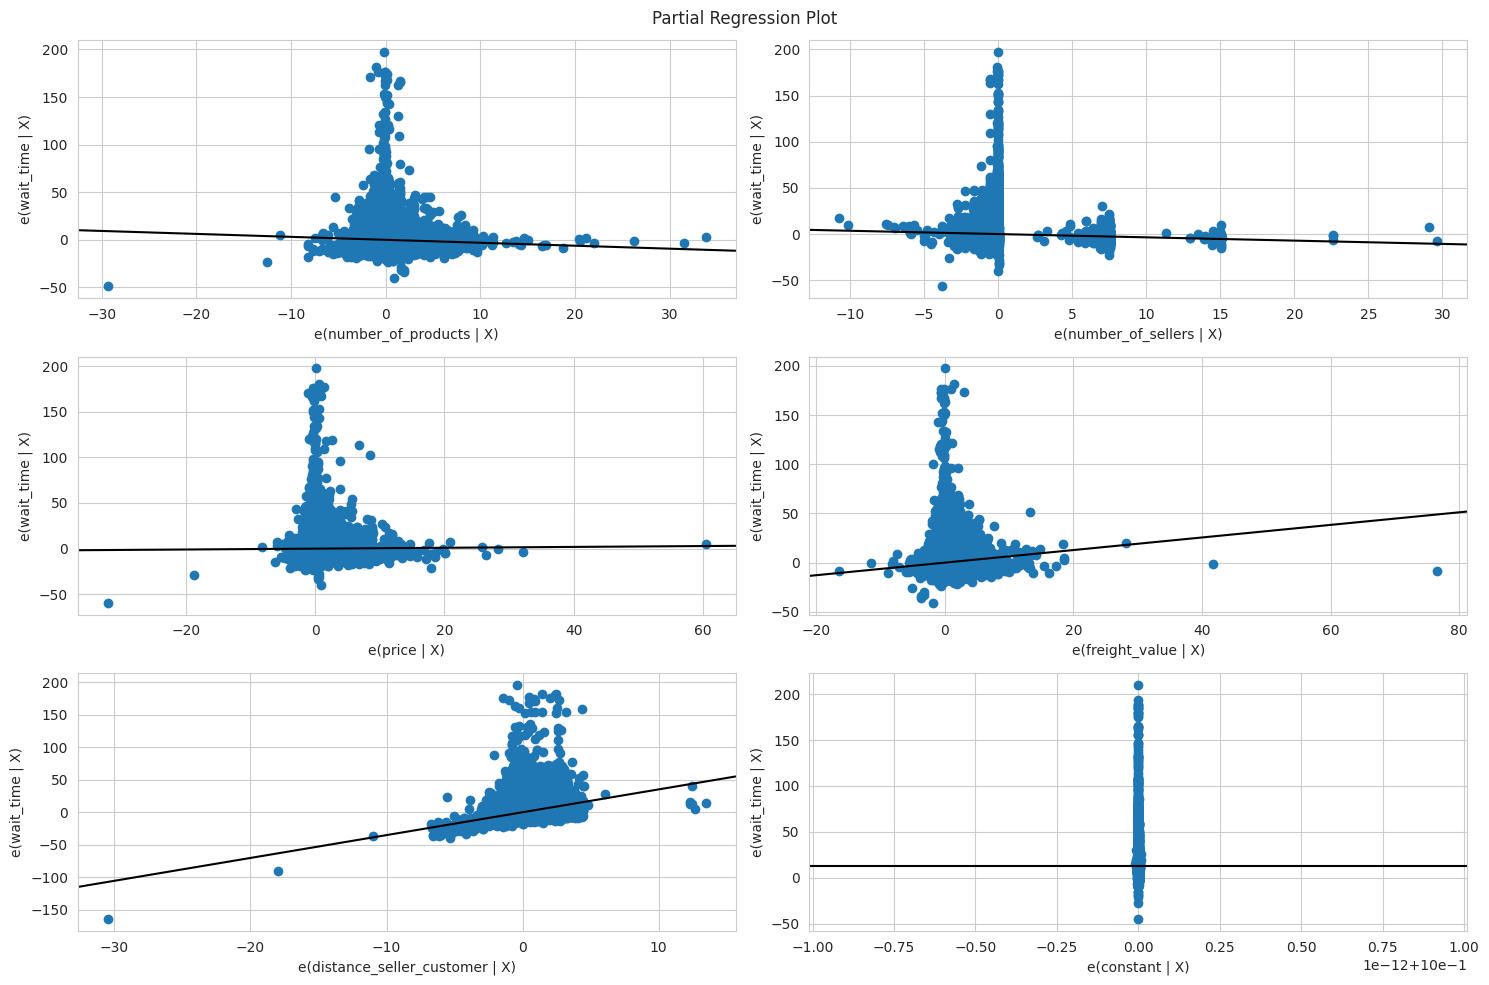

In [25]:
fig = plt.figure(figsize=(15,10))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

**How to read these graphs ?**

👉 Let's focus - for instance - on the graph in the bottom left corner:

<u>Partial regression of `wait_time` against `distance`</u>

- Each point is an order in our dataset


- `y-axis`: residuals of the `wait_time`, using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- `x-axis`: residuals of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

❓ **Are the residuals normally distributed?**  
If the <span style="color:blue">blue</span> points are aligned on the <span style="color:red">red line</span> which is the identity function, the variable has a Gaussian distribution !

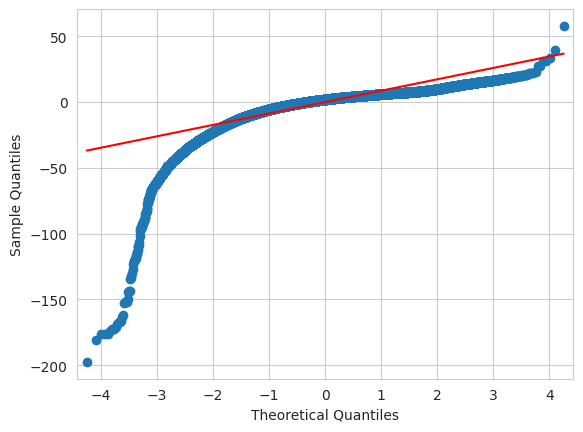

In [28]:
sm.qqplot(residuals, line='s')
plt.show()

#### Check residuals vs. fitted to see if we can detect any non-random pattern

(0.0, 50.0)

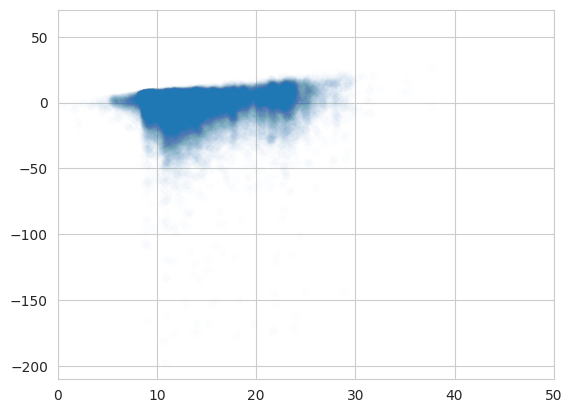

In [29]:
sns.scatterplot(x = y_pred, y = residuals, alpha=0.01)
plt.xlim(xmin=0, xmax=50)